<h1 style="text-align: center;">7. Clasificación</h1>
<h2 style="text-align: center;">Redes neuronales artificiales</h2>

------------------------------------------------------------------------


Elaborado por el Dr. Carlos Francisco Méndez para la asignatura de Introducción a la Ciencia de Datos de la Licenciatura en Ciencias Genómicas

## Objetivo

Entrenar un modelo de red neuronal artificial profunda para resolver una tarea de clasificación multiclase usando PyTorch.

Notebook adaptado de la [Capacitación oficial de PyTorch.](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## Descripción de la tarea

En este taller vamos a user el conjunto de datos FashionMNIST. El modelo debe clasificar imágenes de elementos de vestimenta en una de 10 posibles categorías:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot        
    
Ejemplos de entrada:
<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 50%;"
    src="fashion-mnist-sprite.png" 
    alt="FashionMNIST">
</img>



------------------------------------------------------------------------


## Importación de librerías

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Descarga y creación de conjuntos de entrenamiento y prueba

Usaremos dos objetos de PyTorch para manejo de datos:
* Dataset: permite almacenar conjuntos de datos en forma de `Ejemplo - Etiqueta`.
* DataLoader: permite iterar a través del conjunto de datos.

El módulo `torchvision.datasets` contiene objetos de la clase `Dataset` para acceder a diversos conjuntos de datos disponibles para uso libre. 

Usaremos el conjunto de datos `FashionMNIS`. El argumento `transform` permite transformar los datos en tensores con el parámetro ToTensor() y el argumento `download=True` indica que el dataset debe ser descargado.

Dividimos el conjunto de datos en dos subconjuntos. Unos será usado para el entrenamiento de la red (`train_data`) y el otro para evaluarla (`test_data`).


In [2]:
# Load datasets
data = pd.read_csv('../data/cvd_transformed.csv')
data


,id,age_days,age_year,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse,bmi_clasification,pulse_clasification
0,0,18393,50.391781,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30,Peso normal,2
1,1,20228,55.419178,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50,Obesidad,4
2,2,18857,51.663014,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60,Peso normal,4
3,3,17623,48.282192,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50,Sobrepeso,4
4,4,17474,47.873973,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40,Peso normal,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61834,99988,20609,56.463014,1,159,72.0,130,90,2,2,0,0,1,0,28.479886,40,Sobrepeso,3
61835,99991,19699,53.969863,1,172,70.0,130,90,1,1,0,0,1,1,23.661439,40,Peso normal,3
61836,99993,19240,52.712329,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,40,Sobrepeso,3
61837,99998,22431,61.454795,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,55,Sobrepeso,4


------------------------------------------------------------------------


In [5]:
# Define the features and target variable
features = ['age_year', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'pulse']
X = data[features]
y = data['cardio']

# Escalamiento de datos
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print("Datos")
print(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Datos
[[-0.41252876 -0.51957914 -0.38479629 ...  0.49289452 -1.12322809
  -1.70180269]
 [ 0.33066899  2.48212624 -0.38479629 ...  0.49289452  1.82539772
   0.78361434]
 [-0.22460301  2.48212624 -0.38479629 ... -2.02883165 -0.77271049
   2.02632286]
 ...
 [-0.06948326 -0.51957914 -0.38479629 ...  0.49289452  0.00528188
  -0.45909417]
 [ 1.2229113  -0.51957914  1.38952461 ... -2.02883165  0.04437073
   1.4049686 ]
 [ 0.45703285  0.98127355 -0.38479629 ...  0.49289452 -0.45290544
  -0.45909417]]


In [8]:
# Ensure X_train and y_train are numpy arrays
X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train

X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test
y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for classification labels

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Creación de `DataLoader`

Definimos un tamaño de lote para que la red ajuste sus pesos cada 64 ejemplos (`batch_size = 64`).

Creamos dos objetos `DataLoader` para iterar ambos conjuntos de datos por lotes.


In [10]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


### Observación del DataLoader

Vamos a iterar sobre el DataLoader de prueba (`test_dataloader`) para ver observar la dimesionalidad del primer lote y su categoría.

In [11]:
for X, y in test_dataloader:
    print(f"Dimensionalidad de datos X [TamañoLote, CanalImag, LargoImag, AnchoImag]: {X.shape}")
    print(f"Dimensionalidad de categorías y: {y.shape}, tipo de categorías: {y.dtype}")
    break

Dimensionalidad de datos X [TamañoLote, CanalImag, LargoImag, AnchoImag]: torch.Size([64, 8])
Dimensionalidad de categorías y: torch.Size([64]), tipo de categorías: torch.int64


------------------------------------------------------------------------


## Definición de la red neuronal

### Definición de `device` para entrenamiento


In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device a utulizar: {device}")


Device a utulizar: cpu


### Definición de arquitectura de la red neuronal

Creamos la clase `RedNeuronal` a partir de la clase base [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Esta clase será definida de acuerdo a la arquitectura de red que deseamos entrenar.

Debemos definir:
- Capas
- Nodos por capa
- Función de activación
- Procesamiento hacia adelante de la red (`forward`)

Al final indicamos que la red debe crearse en el `device` definido anteriormente.


In [18]:
# Define modelo
class RedNeuronal(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a sequential model without the Flatten layer and adjust input size to 8
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 512),  # Adjust input size to 8 (number of features)
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)  # Change this to the appropriate number of output classes, e.g., 2 if binary
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Instantiate the model with the corrected input size
model = RedNeuronal().to(device)

print(model)

RedNeuronal(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Definición de función de pérdida y optimizador

Para que la red neuronal aprenda debemos utilizar una [función de pérdida o loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) que mida las predicciones de la red y un [optimizador](https://pytorch.org/docs/stable/optim.html) que ajuste los pesos de la red neuronal para intenter predecir cada vez mejor, esto es, diminuir el valor de la función de pérdida.

La función de pérdida más recomendada para resolver tareas de clasificación multiclase es la Entropía crusada (`CrossEntropyLoss`).

El optimizador más sencillo es uno basado de el algortimo de Descenso por gradiente estocástico (`SGD`). La tasa de aprendizaje (learning rate o `lr`) será definida como 0.001.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

### Definición de método de entrenamiento (`train`)

Esto incluye procesar los datos del `dataloader` lote por lote "hacia delante" y calcular el error de predicción de la red, esto es, el valor de la función de pérdida. Luego debemos propagar el error de predicción "hacia atrás" de la red para ajustar los pesos de los nodos. En cada iteración, la red ajustará los pesos para predecir cada vez mejor.


In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Valor de función de pérdida: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Definición de método de prueba (`test`)

Esto incluye procesar los datos de prueba lote por lote, esto es, hacer que la red previamente entrenada realice predicciones sobre estos datos y acumular tanto el error (valor de la función de perdida) como los aciertos de la red (valor de exactitud o `Accuracy`).


In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Fase de prueba: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

------------------------------------------------------------------------


## Entrenamiento de la red neuronal

Ejecutamos los métodos de entrenamiento (`train`) y prueba (`test`) por un número de épocas (veces que la red entrena usando todos los datos disponibles).

El `train` imprimirá el valor de pérdida por cada 100 lotes. El método `test` imprimirá el valro de pérdida y la exactitud de predicción.


In [22]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Valor de función de pérdida: 2.329883  [   64/49471]
Valor de función de pérdida: 1.887639  [ 6464/49471]
Valor de función de pérdida: 1.385881  [12864/49471]
Valor de función de pérdida: 1.091769  [19264/49471]
Valor de función de pérdida: 0.918233  [25664/49471]
Valor de función de pérdida: 0.770281  [32064/49471]
Valor de función de pérdida: 0.677655  [38464/49471]
Valor de función de pérdida: 0.720853  [44864/49471]
Fase de prueba: 
 Accuracy: 67.7%, Avg loss: 0.680100 

Epoch 2
-------------------------------
Valor de función de pérdida: 0.670799  [   64/49471]
Valor de función de pérdida: 0.663708  [ 6464/49471]
Valor de función de pérdida: 0.560737  [12864/49471]
Valor de función de pérdida: 0.549386  [19264/49471]
Valor de función de pérdida: 0.577794  [25664/49471]
Valor de función de pérdida: 0.572440  [32064/49471]
Valor de función de pérdida: 0.554148  [38464/49471]
Valor de función de pérdida: 0.643440  [44864/49471]
Fase de prueba: 

------------------------------------------------------------------------


## Guardar modelo entrenado

Para guardar nuestro modelo entrenado, almacenamos en un archivo los pesos ajustados finales de la red neuronal.


In [23]:
torch.save(model.state_dict(), "model.pth")
print("Guardamos modelo entrenado en model.pth")

Guardamos modelo entrenado en model.pth


------------------------------------------------------------------------


## Fase de inferencia


### Cargar modelo entrenado

Para usar nuestro modelo entrenado, creamos una instancia de la red neuronal y le cargamos los pesos almacenados.


In [24]:
model = RedNeuronal().to(device)
model.load_state_dict(torch.load("model.pth"))

C:\Users\cvill\AppData\Local\Temp\ipykernel_27428\2627455650.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

### Usar modelo entrenado

Predecir con el modelo entrenado la categoría de nuevos datos. Como ejemplo, usemos la imagen 919 del conjunto de datos de prueba.


Usamos nuestro modelo entrenado en modo de evaluación `model.eval()` y sin ajustes de pesos: `torch.no_grad()`.

Imprimimos la categoría predicha por el modelo y la categoría verdadera.

In [26]:
classes = [0,1]

model.eval()
x, y = test_dataset[5][0], test_dataset[5][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Categoría predicha: "{predicted}", Categoría verdadera: "{actual}"')

Categoría predicha: "0", Categoría verdadera: "0"


------------------------------------------------------------------------


In [28]:
# Put model in evaluation mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Get model predictions
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)  # Get predicted class
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

In [29]:
# Calculate Precision, Recall, F1-Score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Calculate AUROC (Assumes binary classification with classes [0, 1])
# For AUROC, we need the raw scores, not the final predictions, so we use `outputs` before argmax in a real scenario.
# This example assumes `preds` corresponds to the probability or score for the positive class.
# If not, you'll need to modify it accordingly.
auroc = roc_auc_score(all_labels, all_preds)

# Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUROC: {auroc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)


Precision: 0.6701
Recall: 0.6249
F1 Score: 0.6467
AUROC: 0.6791
Confusion Matrix:
 [[4858 1767]
 [2154 3589]]


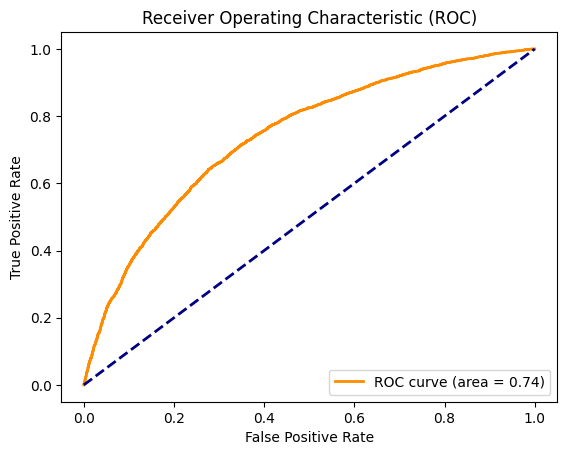

In [31]:
# Get predicted probabilities for the positive class
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
        all_probs.extend(probs.cpu().numpy())

# Calculate ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
